In [13]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy as sql

from rmexp import dbutils, config
from rmexp.schema import models
from logzero import logger
import operator
import itertools

In [14]:
sess = dbutils.get_session()

# get the first frame that state transition happened
exp_names = ['lego-tr{}'.format(idx) for idx in range(1, 5)]
exp_names.append('lego-tr6')
ss = []
for exp_name in exp_names:
    exp_ss = [[int(item.idx), item.val] for item in sess.query(models.SS.val, 
                                           models.SS.name, 
                                           models.SS.index.label('idx')).filter(models.SS.name==exp_name).all()]
    ss.append(exp_ss)
sess.close()

## Effects of Detecting Board on the Client

In [15]:
# find # of frames that do not have boards
for exp_idx, exp_ss in enumerate(ss):
    print('==================lego-tr{}============='.format(exp_idx+1))
    no_board_fss = [fss for fss in exp_ss if ('Failed at stage 1' in fss[1] 
                                              or 'Failed at stage 2' in fss[1] 
                                              or 'Too little black dots, maybe image blurred' in fss[1]
                                              or 'black dots are not inside the board' in fss[1]
                                             )]
    print('# without board {}, # total frames {}'.format(len(no_board_fss), len(exp_ss)))

==================lego-tr1=============
# without board 1849, # total frames 2606
==================lego-tr2=============
# without board 1680, # total frames 2982
==================lego-tr3=============
# without board 1432, # total frames 2859
==================lego-tr4=============
# without board 1549, # total frames 3111
==================lego-tr5=============
# without board 1652, # total frames 4084


In [16]:
# The above method consecutive frames do not work, 
# as 3 consecutive frames will miss a state in tr1, but false classify ones in tr3

# Use cumulative method to detect stage
def detect_stage(exp_ss, cumulative_num):
    """Detected stages from extracted symbolic states.
    
    cumulative_num: number of cumulative detection of frames for the results to be counted
    """
    exp_stages = []
    cnt = 0
    staging_fss = None
    for (idx, fss) in enumerate(exp_ss):
        if '[[' in fss[1]:
            if staging_fss is None:
                staging_fss = fss
                cnt = 1
            else: # count if consecutive appearance
                if fss[1] == staging_fss[1]:
                    cnt += 1
                    if cnt >= cumulative_num and (len(exp_stages) == 0 or (fss[1] != exp_stages[-1][1])):
                        exp_stages.append(fss)
                else:
                    staging_fss = fss
                    cnt = 1
    return exp_stages

In [17]:
# it takes about 60ms on a 2.3Ghz single core to process if a board is in the frame or not
import numpy as np

def print_stage_info(detected_stages):
    stage_times = []
    print(detected_stages[0])
    for (idx, stage) in enumerate(detected_stages[1:]):
        print('stage {}:'.format(idx+1))
        print(stage)
        stage_time = stage[0] - detected_stages[idx][0]
        print('took {} frames'.format(stage_time))
        stage_times.append(stage_time)
    stage_times = np.array(stage_times)
    print('average stage time: {}, min {}, max {}'.format(np.average(stage_times), 
                                                          np.min(stage_times), 
                                                          np.max(stage_times)))

# find all the detected stage changes, there should be 7 steps in total
dataset_stage_info = []
for exp_idx, exp_ss in enumerate(ss):
    logger.debug('==================lego-tr{}============='.format(exp_idx+1))
    detected_stages = detect_stage(exp_ss, cumulative_num=5)
    logger.debug('valid? {}. Expected number of states is 7, actual {}'.format(len(detected_stages)==7, len(detected_stages)))
    dataset_stage_info.append(detected_stages)

[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:21] ==================lego-tr1=============
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:23] valid? True. Expected number of states is 7, actual 7
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:21] ==================lego-tr2=============
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:23] valid? True. Expected number of states is 7, actual 7
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:21] ==================lego-tr3=============
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:23] valid? True. Expected number of states is 7, actual 7
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:21] ==================lego-tr4=============
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:23] valid? True. Expected number of states is 7, actual 7
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:21] ==================lego-tr5=============
[D 190503 12:08:19 <ipython-input-17-35e2cd697411>:23] valid? True. Expected number of st

[D 190503 12:08:19 <ipython-input-18-ddd136e45b14>:4] [[ 291  513  817 1177 1668 2105 2426]
     [ 239  686 1073 1395 1918 2300 2766]
     [ 321  708 1118 1498 1875 2324 2821]
     [ 260  591 1206 1598 1992 2500 2893]
     [ 184  661 1477 2281 2746 3292 3871]]
[I 190503 12:08:19 <ipython-input-18-ddd136e45b14>:6] stage length (# s) 
    [[  7.4         10.13333333  12.          16.36666667  14.56666667  10.7       ]
     [ 14.9         12.9         10.73333333  17.43333333  12.73333333
       15.53333333]
     [ 12.9         13.66666667  12.66666667  12.56666667  14.96666667
       16.56666667]
     [ 11.03333333  20.5         13.06666667  13.13333333  16.93333333  13.1       ]
     [ 15.9         27.2         26.8         15.5         18.2         19.3       ]]
[I 190503 12:08:19 <ipython-input-18-ddd136e45b14>:7] avg stage length by user 
    [ 11.86111111  14.03888889  13.88888889  14.62777778  20.48333333]
[I 190503 12:08:19 <ipython-input-18-ddd136e45b14>:8] avg stage length by st

<IPython.core.display.Javascript object>


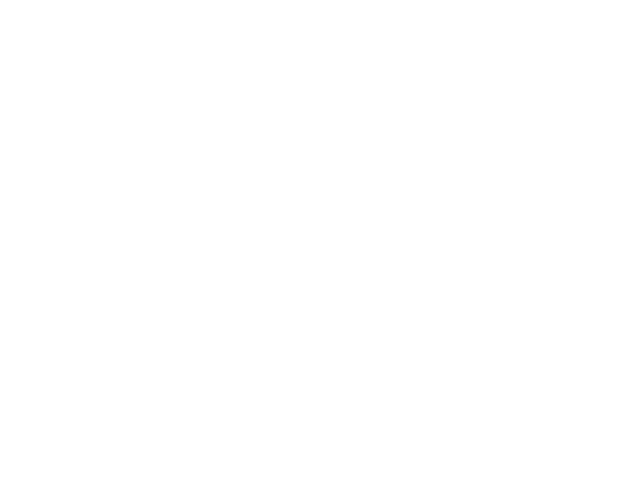

In [18]:
# get dataset stage information
# avg stage length 14.13, min 6.6, max 27.2
dataset_stage_frame_idx = np.array(dataset_stage_info)[:, :, 0].astype('int')
logger.debug(dataset_stage_frame_idx)
dataset_stage_length = (dataset_stage_frame_idx[:, 1:] - dataset_stage_frame_idx[:, :-1])/30.0
logger.info("stage length (# s) \n{}".format(dataset_stage_length))
logger.info("avg stage length by user \n{}".format(np.mean(dataset_stage_length, axis=1)))
logger.info("avg stage length by stage \n{}".format(np.mean(dataset_stage_length, axis=0)))
logger.info("avg stage length {:.2f}, min {}, max {}".format(np.mean(dataset_stage_length), 
                                                         np.min(dataset_stage_length), 
                                                         np.max(dataset_stage_length)))
def plot_stage_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('stage duration (s)');
    plt.title('Lego Stage Duration')

plot_stage_duration(dataset_stage_length)

fitted Gaussian Model has mu 14.98 and sigma 4.25589438744


<IPython.core.display.Javascript object>


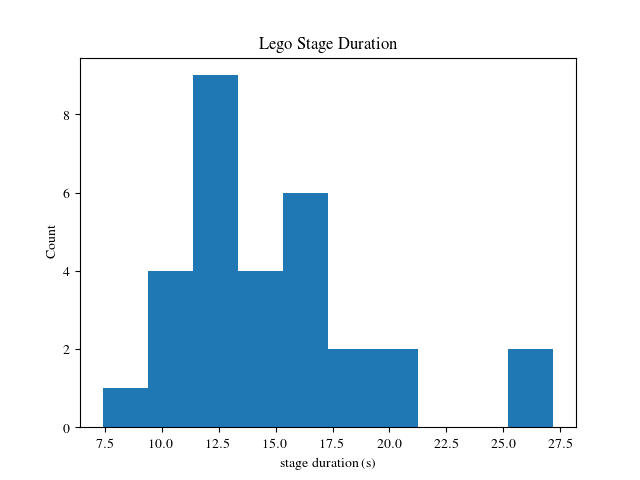

<IPython.core.display.Javascript object>


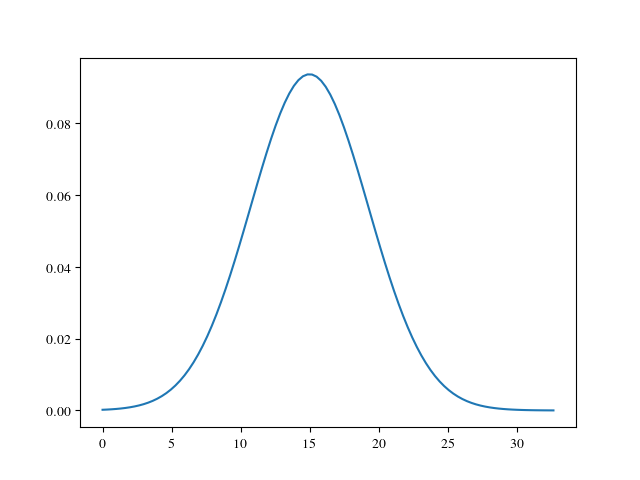

In [19]:
%matplotlib notebook

# fit a gaussian model using MLE for stage duration
# the mean is just sample mean, and sigma is just sample std
from scipy.stats import norm

def fit_gaussian(data):
    data = data.flatten()
    return np.mean(data), np.std(data)

stage_duration_gaussian_model = fit_gaussian(dataset_stage_length)
print('fitted Gaussian Model has mu {} and sigma {}'.format(*stage_duration_gaussian_model))
plot_stage_duration(dataset_stage_length)
plt.figure()
x = np.linspace(0, np.max(dataset_stage_length)*1.2, 100)
plt.plot(x, norm.pdf(x, *stage_duration_gaussian_model));

## Dynamic Sampling Rate

k consecutive frames, S is the sampling period, p is the processing delay for a frame (use average as an estimate), b is the bound:

(k+1) * S + p <= b

1000/S <= max_sampling_frequency

1000/S <= min(maximum processing rate, network transmission rate)

So for lego (370 is the average full processing delay from trace 1 to 5, running on 2 cloudlet cores)

(5 + 1) * S + 370 <= 2700

1000/S <= 30
1000/S <= min(maximum processing rate, network transmission rate)

Then use the CDF of the curve as the dynamic sampling rate ranged from 2.58 Hz to 30 Hz

sr_min is 2.58286698235


<IPython.core.display.Javascript object>


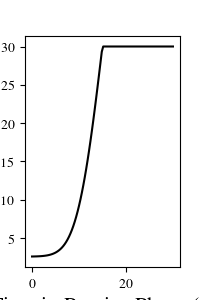

In [39]:
# implement dynamic sample rate
def get_average_full_proc_delay():
    ds_full_proc_delay = []
    for exp_name in exp_names:
        full_proc_idx = [int(item.idx) for item in sess.query(models.SS.val, models.SS.name, 
                                           models.SS.index.label('idx')).filter(
                                            models.SS.name==exp_name).filter(
                                            models.SS.val.like("%[[%")
                                            ).all()]
        proc_delay = [(int(item.val), int(item.idx)) for item in sess.query(models.LegoLatency.val, models.LegoLatency.name, 
                                           models.LegoLatency.index.label('idx')).filter(
                                            models.LegoLatency.name==exp_name).all()]
        full_proc_delay = map(lambda x: int(x[0]), 
                              (filter(lambda (val, idx): idx in full_proc_idx, proc_delay)))
        ds_full_proc_delay.append(full_proc_delay)
    ds_full_proc_delay = list(itertools.chain.from_iterable(ds_full_proc_delay))
    return np.mean(np.array(ds_full_proc_delay))

# sr_min is 370
avg_full_proc_delay = round(get_average_full_proc_delay())
sr_min = 1000.0 / ((2700 - avg_full_proc_delay) / 6.0)
print('sr_min is {}'.format(sr_min))
sr_max = 30.0
recover_factor = 2
dynamic_sample_rate = lambda x: sr_min + float(sr_max - sr_min) * min(recover_factor * norm.cdf(
    x, *stage_duration_gaussian_model), 1.0)

def plot_lego_sample_rate():
    x=np.linspace(0, 30, 100)
    y = np.vectorize(dynamic_sample_rate, otypes=[np.float])(x)
    plt.figure(figsize=(2,3))
    plt.plot(x, y, 'black')
#     plt.title('Adaptive Sampling Frequency', fontsize=20)
    plt.xlabel('Time in Passive Phase (s)', fontsize=16)
    plt.ylabel('Sampling Rate (Hz)', fontsize=18)
    plt.savefig('fig-lego-adaptive-sr.pdf', bbox_inches='tight')

plot_lego_sample_rate()

In [35]:
# Simulate Dynamic sampling rate!
# generate dynamic sampling rate for traces
def get_check_transition_func(cumulative_num):
    def check_transition(app_state, fss):
        """find next stage from the vss"""
        staging_fss, last_stage_fss, cnt = app_state
        if '[[' in fss[1]:
            if staging_fss is None:
                staging_fss = fss
                cnt = 1
            else: # count if consecutive appearance
                if fss[1] == staging_fss[1]:
                    cnt += 1
                    if cnt >= cumulative_num and (
                        last_stage_fss is None or fss[1] != last_stage_fss[1]):
                        return True, (None, fss, 0)
                else:
                    staging_fss = fss
                    cnt = 1
        return False, (staging_fss, last_stage_fss, cnt)
    return check_transition

# stop slowing down when x is larger than 15
def simulate_dynamic_sample_rate(sample_rate_func, max_mute_t):
    """Simulate dynamic sampling rate.
    sample_rate_func: function of dynamic sample rate. Input should the the time after a given instruction.
    max_mute_t: maximum time this sample_rate_func is in place
    
    Return simulated trace, stage_frame_idx
    """
    import copy
    sr = 30.0
    
    def get_mute_fr(sample_rate_func, fss, mute_st):
        dysr = sample_rate_func((fss[0] - mute_st) / float(sr))
        mute_fr = int(1.0 / dysr * sr)
        if dysr >= 30.0 - 10e-4:
            mute_fr = 0
        return mute_fr
    check_transition = get_check_transition_func(5)
        
    max_mute_fr = int(max_mute_t * sr)
    dy_ss = []
    dy_stage_frame_idx = []
    for vid, exp_ss in enumerate(ss):
        dyexp_ss = copy.deepcopy(exp_ss)
        stage_frame_idx = []
        app_state = (None, None, 0)
        mute_st = None
        mute_fr = 0
        for fss in dyexp_ss:
            # check mute
            if mute_fr > 0:
                fss[1] = None
                mute_fr -= 1
                continue

            if mute_st is not None and (fss[0] - mute_st) / sr > max_mute_t:
                mute_st = None
                mute_fr = 0

            transition, app_state = check_transition(app_state, fss)
            if transition:
                mute_st = app_state[1][0]
                stage_frame_idx.append(mute_st)

            if mute_st is not None:
                mute_fr = get_mute_fr(sample_rate_func, fss, mute_st)
            
        dy_ss.append(dyexp_ss)
        dy_stage_frame_idx.append(stage_frame_idx)
    return dy_ss, dy_stage_frame_idx

Difference in frames: 
[[ 0 24 14 11  0  4 23]
 [ 0  5 13 13  0 11  0]
 [ 0  4  3  4  6 18  2]
 [ 0  9  0  7 12  0 26]
 [ 0  0  0  0  0  0  0]]
average: 5.97142857143, std: 7.61384346076
supressed # samples: 1910.0, percentage: 0.732924021489
supressed # samples: 2163.0, percentage: 0.725352112676
supressed # samples: 2005.0, percentage: 0.701294158797
supressed # samples: 2143.0, percentage: 0.688846030215
supressed # samples: 2287.0, percentage: 0.559990205681


<IPython.core.display.Javascript object>


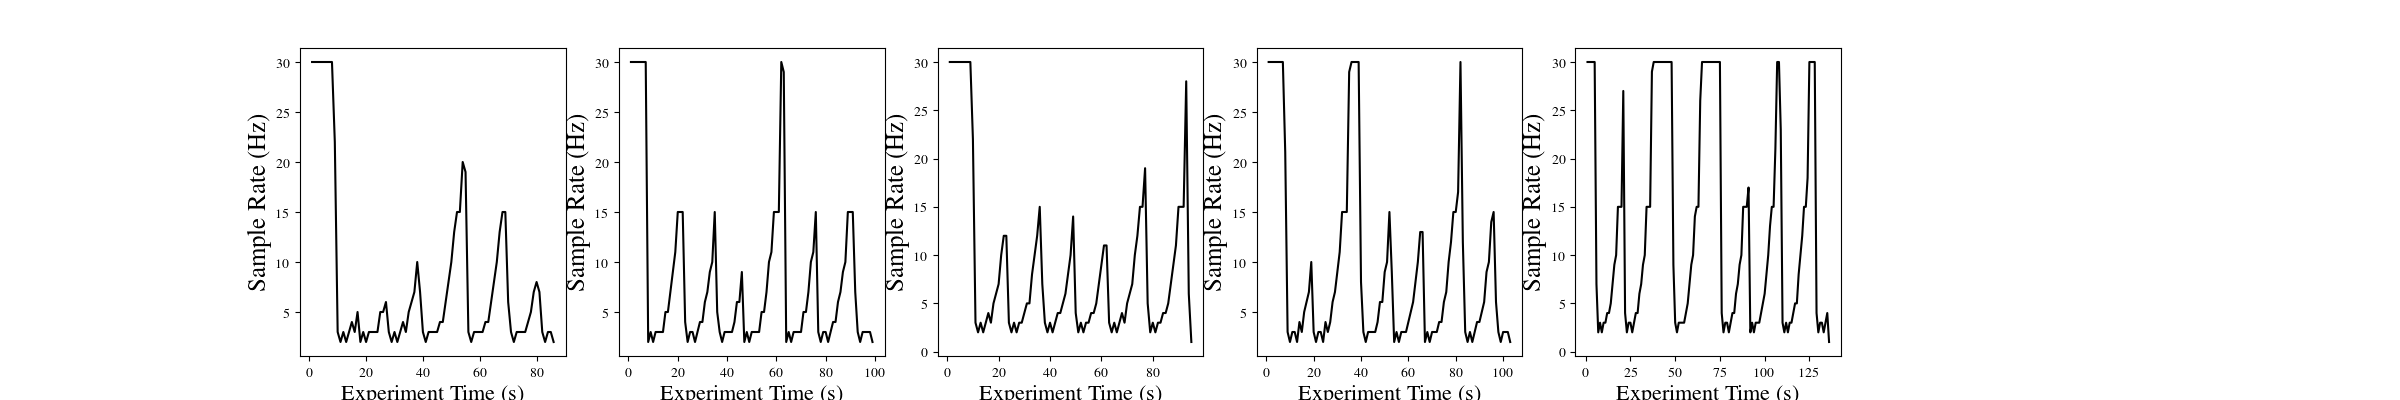

<IPython.core.display.Javascript object>


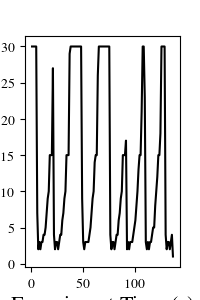

In [40]:
# show and plot dynamic sampling rate
dy_ss, dy_stage_frame_idx = simulate_dynamic_sample_rate(dynamic_sample_rate, np.max(dataset_stage_length))
dy_stage_frame_idx = np.array(dy_stage_frame_idx)
# print(dy_stage_frame_idx)
# print(dataset_stage_frame_idx)
dy_stage_frame_diff = dy_stage_frame_idx - dataset_stage_frame_idx
print('Difference in frames: ')
print(dy_stage_frame_diff)
print('average: {}, std: {}'.format(np.mean(dy_stage_frame_diff), np.std(dy_stage_frame_diff)))

for idx, dy_exp_ss in enumerate(dy_ss):
    num_suppressed = float(len([item[0] for item in dy_exp_ss if item[1] is None]))
    num_total = float(len(ss[idx]))
    print('supressed # samples: {}, percentage: {}'.format(num_suppressed, num_suppressed/num_total))

def plot_dy_sampling_freq(dy_exp_ss):
    import collections
    sampled_idx = [item[0] for item in dy_exp_ss if item[1] is not None]
    sampled_idx = map(lambda x: int(x/30.0), sampled_idx)
    freq_counter = collections.Counter(sampled_idx)
    sorted_freqs = sorted(freq_counter.items(), key=lambda pair: pair[0])
    x, y = zip(*sorted_freqs)
    plt.plot(x[1:], y[1:], 'black')
    plt.xlabel('Experiment Time (s)',  fontsize=16)
    plt.ylabel('Sample Rate (Hz)', fontsize=18)


# plot a single trace
plt.figure(figsize=(24, 4))
for (h_idx, dy_exp_ss) in enumerate(dy_ss):
    plt.subplot(1, len(dy_ss)+1, h_idx+1)
    plot_dy_sampling_freq(dy_exp_ss)

plt.figure(figsize=(2, 3))
dy_exp_ss = dy_ss[-1]
plot_dy_sampling_freq(dy_exp_ss)
plt.savefig('fig-lego-example-sr.pdf', bbox_inches='tight')

### Baseline to use to compare with dynamic sampling rate

In [334]:
# some baseline frequency sampling savings and results
import copy
def print_stage_diff(stage_info, ref_stage_frame_idx):
    dataset_stage_frame_idx = np.array(stage_info)[:, :, 0].astype('int')
    stage_frame_diff = dataset_stage_frame_idx - ref_stage_frame_idx
    # logger.debug('Difference in frames: {}'.format(stage_frame_diff))
    logger.debug('average: {}, std: {}'.format(np.mean(stage_frame_diff), np.std(stage_frame_diff)))

bsr = 30.0
srs = [15.0, 10.0]
for sr in srs:
    assert(bsr % sr == 0)
    period = int(bsr / sr)
    logger.info('sampling rate: {}, period: {}'.format(sr, period))
    sr_ss = copy.deepcopy([exp_ss[0::period] for exp_ss in ss])
    sr_ds_stage_info = []
    for sr_exp_ss in sr_ss:
        sr_ds_stage_info.append(detect_stage(sr_exp_ss, 5))
    print_stage_diff(sr_ds_stage_info, dataset_stage_frame_idx)


[I 190428 19:50:36 <ipython-input-334-a052d5d4242c>:14] sampling rate: 15.0, period: 2
[D 190428 19:50:36 <ipython-input-334-a052d5d4242c>:7] average: 8.97142857143, std: 9.37012186012
[I 190428 19:50:36 <ipython-input-334-a052d5d4242c>:14] sampling rate: 10.0, period: 3
[D 190428 19:50:36 <ipython-input-334-a052d5d4242c>:7] average: 14.6857142857, std: 9.9362868275


## Ping-Pong Duty Cycle

Uses "Cannot find Table" as a method to suppress 1s

In [7]:
sess = dbutils.get_session()

# get the first frame that state transition happened
exp_names = ['pingpong-tr{}'.format(idx) for idx in range(1, 6)]
ss = []
for exp_name in exp_names:
    exp_ss = [[int(item.idx), item.val] for item in sess.query(models.SS.val, 
                                           models.SS.name, 
                                           models.SS.index.label('idx')).filter(models.SS.name==exp_name).all()]
    ss.append(exp_ss)
sess.close()

state_no_table_msgs = [
    'Cannot find table',
    'Detected table too small',
    'Table top line too short',
    'Table top line tilted too much',
    "Table doesn't occupy bottom part of image",
    'Angle between two side edge not right',
    'Valid area too small after rotation'
]

def has_table(state):
    for msg in state_no_table_msgs:
        if msg in state:
            return False
    return True

In [37]:
def interval_extract(input_list): 
    """Extract continuous intervals out of a list of items"""
    length = len(input_list) 
    i = 0
    while (i< length): 
        low = input_list[i] 
        while i <length-1 and input_list[i]+1 == input_list[i + 1]: 
            i += 1
        high = input_list[i] 
        if (high - low >= 1): 
            yield [low, high] 
        elif (high - low == 1): 
            yield [low, ] 
            yield [high, ] 
        else: 
            yield [low, ] 
        i += 1

ds_long_no_table = [[], []]
long_no_table_thresh = 60
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))
    no_table_idx = [item[0] for item in exp_ss if not has_table(item[1])]
    no_table_intervals = list(interval_extract(no_table_idx))
    long_no_table_intervals = zip(*[[item[0], item[1]-item[0]] for 
                               item in no_table_intervals if len(item) > 1 and item[1] - item[0] > long_no_table_thresh])
    logger.info(long_no_table_intervals)
    ds_long_no_table[0].append(long_no_table_intervals[0])
    ds_long_no_table[1].append(long_no_table_intervals[1])

[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace1 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(56, 200), (82, 125)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace2 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(108, 961, 1342, 2398), (67, 91, 135, 170)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace3 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(344, 813, 1176), (112, 70, 61)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace4 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(771,), (88,)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace5 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(90, 1543), (111, 79)]


<IPython.core.display.Javascript object>


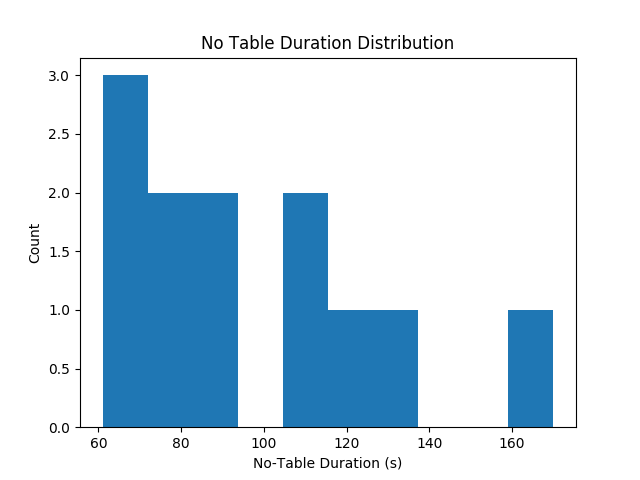

In [38]:
%matplotlib notebook
def plot_no_table_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('No-Table Duration (s)');
    plt.title('No Table Duration Distribution')

plot_no_table_duration(np.array([item for sublist in ds_long_no_table[1] for item in sublist]))

In [ ]:
# plot key frame and then use supression as a way
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))